In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error

# # AAPL 2024 (yfinance)

In [2]:
import yfinance as yf

aapl = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
aapl = aapl['Close']
aapl.head(10)

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2015-01-02,24.261053
2015-01-05,23.577572
2015-01-06,23.579796
2015-01-07,23.910435
2015-01-08,24.829126
2015-01-09,24.855759
2015-01-12,24.243288
2015-01-13,24.458542
2015-01-14,24.365347


In [18]:
df = aapl
df.head()

Ticker,AAPL
Date,
2015-01-02,24.261053
2015-01-05,23.577572
2015-01-06,23.579796
2015-01-07,23.910435
2015-01-08,24.829126


In [19]:
df.tail()

Ticker,AAPL
Date,
2024-12-23,254.367020
2024-12-24,257.286652
2024-12-26,258.103729
2024-12-27,254.685867
2024-12-30,251.307861


In [20]:
df = df.fillna(method = 'ffill')
df.tail(10)

Ticker,AAPL
Date,
2024-12-16,250.151962
2024-12-17,252.583344
2024-12-18,247.172562
2024-12-19,248.906387
2024-12-20,253.589767
2024-12-23,254.367020
2024-12-24,257.286652
2024-12-26,258.103729
2024-12-27,254.685867


In [21]:
df['LogAAPL']= np.log(df['AAPL'])
df

Ticker,AAPL,LogAAPL
Date,,
2015-01-02,24.261053,3.188872
2015-01-05,23.577572,3.160296
2015-01-06,23.579796,3.160390
2015-01-07,23.910435,3.174315
2015-01-08,24.829126,3.212017
...,...,...
2024-12-23,254.367020,5.538778
2024-12-24,257.286652,5.550191
2024-12-26,258.103729,5.553362


In [22]:
df2 = df
df2.shape

(2515, 2)

In [23]:
df = df[509:]
df.shape

(2006, 2)

In [24]:
test_period = int(len(df) * 0.2)
train_period = len(df) - test_period

print("train_period:", train_period)
print("test_period:", test_period)

train_period: 1605
test_period: 401


In [25]:
train = df.iloc[:train_period]
test  = df.iloc[train_period:]

In [26]:
series = df['LogAAPL'].dropna().to_numpy()

Tx = 90 # using the past 100 observations to forecast the next one.
Ty = 1 # forecasting only one step ahead
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)]).reshape(-1, Tx, 1)
Y = np.array([series[t+Tx+Ty-1] for t in range(len(series) - Tx-Ty+1)]).reshape(-1, Ty)
N = len(X)

print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (1916, 90, 1) Y: (1916, 1) N: 1916


In [27]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

In [28]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((1515, 90, 1), (1515, 1), (401, 90, 1), (401, 1))

# One-step

In [29]:
n_features = 1 
inputs = keras.Input(shape=(Tx, n_features))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("LSTM_singleOutput_2024.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(Xtrain, Ytrain,
                    epochs=100,
                    validation_data=(Xtest,Ytest),
                    callbacks=callbacks)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 12.1631 - mae: 3.2594 - val_loss: 1.9304 - val_mae: 1.3833
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3556 - mae: 0.5202 - val_loss: 0.1676 - val_mae: 0.3990
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0461 - mae: 0.1549 - val_loss: 0.0763 - val_mae: 0.2528
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0193 - mae: 0.1015 - val_loss: 0.0552 - val_mae: 0.2110
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0261 - mae: 0.1092 - val_loss: 0.0826 - val_mae: 0.2688
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0166 - mae: 0.0921 - val_loss: 0.0560 - val_mae: 0.2165
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0131 - mae: 0.0928 - val_loss: 0.0408 - val_mae: 0.1794
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0141 - mae: 0.0909 - val_loss: 0.0269 - val_mae: 0.1377
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - l

In [30]:
model = tf.keras.models.load_model('LSTM_singleOutput_2024.keras')

In [45]:
train_predictions = model.predict(Xtrain)
test_predictions = model.predict(Xtest)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("MSE:", mean_squared_error(Ytest, test_predictions))
print("MAE:", mean_absolute_error(Ytest, test_predictions))

MSE: 0.0010098552345856934
MAE: 0.025256135098626866


In [47]:
train_indicator = (df.index <= train.index[-1])
test_indicator =  (df.index > train.index[-1])

train_indicator[:Tx] = False

df.loc[train_indicator, '1step_train'] =  train_predictions
df.loc[test_indicator, '1step_test'] =  test_predictions

df['1step_train_orig'] = np.exp(df['1step_train'])
df['1step_test_orig'] = np.exp(df['1step_test'])

In [48]:
df.iloc[899:]

Ticker,AAPL,LogAAPL,1step_train,1step_test,1step_train_orig,1step_test_orig
Date,,,,,,
2020-08-06,110.595573,4.705880,4.712983,NaN,111.383881,NaN
2020-08-07,108.081100,4.682882,4.733419,NaN,113.683632,NaN
2020-08-10,109.652046,4.697312,4.736245,NaN,114.005272,NaN
2020-08-11,106.391006,4.667121,4.739091,NaN,114.330215,NaN
2020-08-12,109.926834,4.699815,4.728088,NaN,113.079132,NaN
...,...,...,...,...,...,...
2024-12-23,254.367020,5.538778,NaN,5.459289,NaN,234.930344
2024-12-24,257.286652,5.550191,NaN,5.464074,NaN,236.057175
2024-12-26,258.103729,5.553362,NaN,5.470544,NaN,237.589371


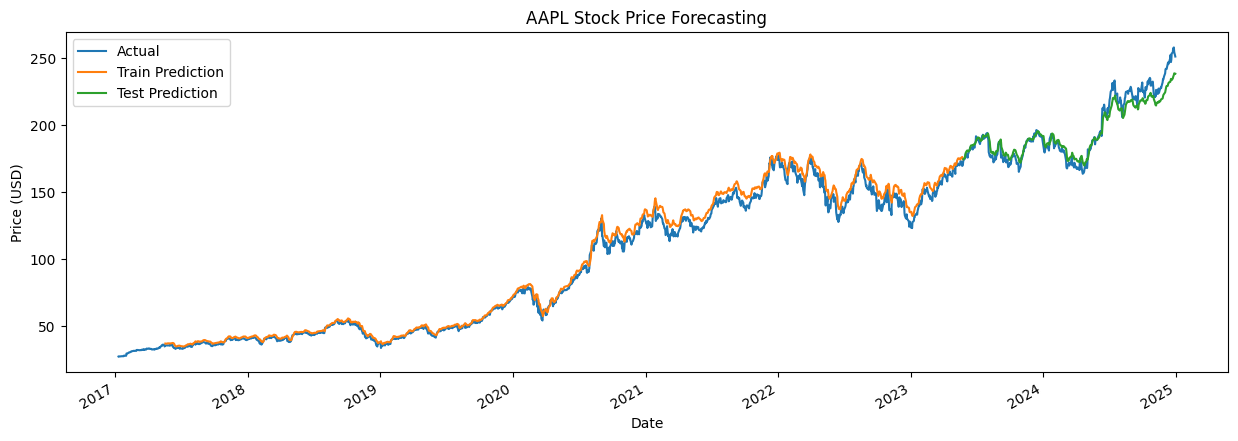

In [34]:
df_plot = df[['AAPL', '1step_train_orig', '1step_test_orig']].plot(figsize=(15, 5))
df_plot.set_title('AAPL Stock Price Forecasting')
df_plot.set_xlabel('Date')
df_plot.set_ylabel('Price (USD)')
df_plot.legend(['Actual', 'Train Prediction', 'Test Prediction'])

plt.show()

# Multi-Step

In [49]:
multistep_predictions = []

# first test input
last_x = Xtest[0]

# Start a loop that will continue until we have the desired number of future forecasts (test_period).
while len(multistep_predictions) < test_period:
  prediction = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(prediction)

  # update the new input
  # The last_x array, which serves as input for the next prediction, is updated. The np.roll(last_x, -1) shifts all elements of last_x one position to the left. 
  # The last element of last_x, which is now freed up, is filled with the last prediction p.
  last_x = np.roll(last_x, -1)
  last_x[-1] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [50]:
df.loc[test_indicator, 'multistep_test'] = multistep_predictions

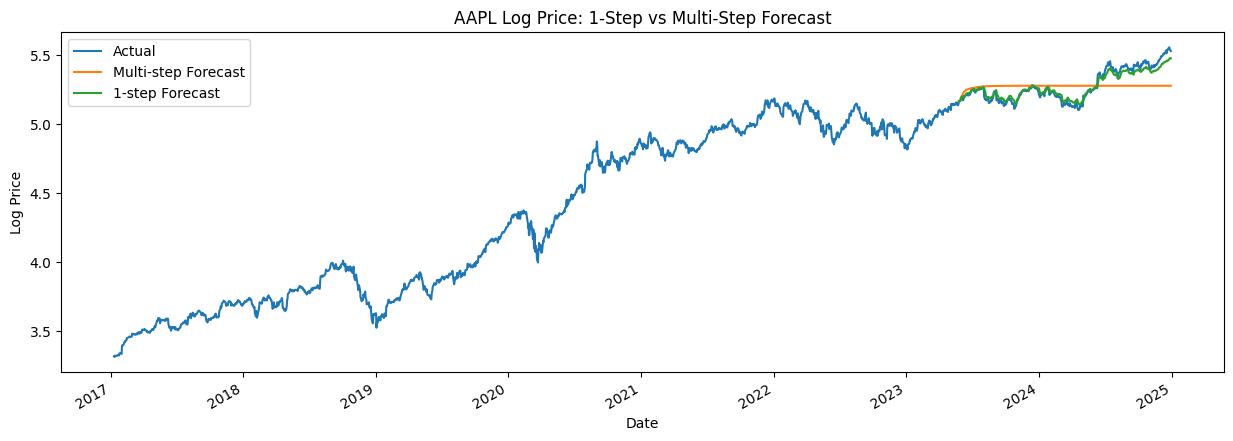

In [51]:
df_plot_both = df[['LogAAPL', 'multistep_test', '1step_test']].plot(figsize=(15, 5))
df_plot_both.set_title('AAPL Log Price: 1-Step vs Multi-Step Forecast')
df_plot_both.set_xlabel('Date')
df_plot_both.set_ylabel('Log Price')
df_plot_both.legend(['Actual', 'Multi-step Forecast', '1-step Forecast'])

plt.show()